<a href="https://colab.research.google.com/github/pranshumalik14/ece421-labs-hw/blob/main/labs/lab2/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Neural Networks

In this lab, we will be creating a neural network from scratch using NumPy.

## 1. Neural Networks using Numpy

We will consider the usual (but limited) defintion of a neural network as a sequence of fully-connected (or dense) layers consisting of nodes with independent activations, except for possibly the output layer where we may have require a multiclass probability distribution as the output or some similarly inferrable vector; we will exclusively consider this case in the lab to classify the `notMNIST` dataset across all 10 alphabets.

We will begin by defining classes for the three central components of any neural network:

1.   Layers (here assumed to be linear and characterized by the number of nodes)
2.   Activation functions that produce the output at any particular layer
3.   Output loss Function that is minimized using gradient descent

### 1.1 Helper Functions, Network Definitions, and Initialization

In [2]:
import numpy as np
import matplotlib.pyplot as plt

We first start with defining the activation functions along with their derivatives, which we will later be able to use in our neural networks during gradient descent (the learning phase).

In [29]:
# activation functions
class ReLU:
    # relu = max(x, 0)    
    @staticmethod
    def __call__(x):
        return np.maximum(x, 0)
    # derivative of relu
    @staticmethod
    def prime(x):
        return np.where(x > 0.0, 1.0, 0.0)

class Softmax:
    # softmax = exp(xi)/sum(exp(xj)), applied row-wise to match data
    @staticmethod
    def __call__(x):
        # subtract maximum for numerical stability
        # while keeping the relative differences intact
        exp = np.exp(x - x.max(axis=1, keepdims=True))
        return exp/exp.sum(axis=1, keepdims=True)

    # we can not use this method for batch processing since it 
    # returns the full Jacobian and will be incompatible with
    # element-wise products
    @staticmethod
    def prime(x): # x should be a vector, flat
        assert len(x) == 1 or len(x.T) == 1
        s = Softmax()(x)
        return np.diag(s) - np.outer(s, s)

# just as an extension of the lab
class Sigmoid:
    # sigmoid = 1 / (1 + exp(-x))
    @staticmethod
    def __call__(x):
        return 1/(1 + np.exp(-x))
    # derivative of sigmoid
    @staticmethod
    def prime(x):
        sigmoid = Sigmoid()(x)
        return sigmoid*(1 - sigmoid)

Now, we define the `Network` class that will be used to define an arbitrary network with dense (fully-connected) layers. The class definition and functionality will expand as we progress through each section. We begin with defining the functions that create the network structure, model parameters, their initialization, and the forward pass through the network.

<TODO: 🚧 theory behind NN structure, notation>

<TODO: 🚧 add info about Xavier initialization>

In [4]:
class Network:
    def __init__(self, layer_sizes, layer_activations):
        assert len(layer_activations) == len(layer_sizes)-1
        self.sizes   = layer_sizes
        self.thetas  = layer_activations

        # xavier init scheme
        n_out = layer_sizes[2:] + [0]
        n_in  = layer_sizes[:-1]
        self.biases  = [np.zeros((1, n)) for n in layer_sizes[1:]] # row-vecs
        self.weights = [np.random.randn(m,n)/np.sqrt((n_out[i]+n_in[i])/2) for 
                        i, (m, n) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:]))]

    def fwd_prop(self, X):
        X_ell = X   # X_0 (input layer)
        for W, b, theta in zip(self.weights, self.biases, self.thetas):
            X_ell = theta((X_ell @ W) + b) # compute X_l, 0 < l <= L
        return X_ell # X_L (output layer)

We will now define the loss function we will use to train our model, along with the accuracy model <>... 🚧🚧🚧🚧. Like lab 1, we will use the cross entropy loss since it maximum likelihood and mutually exlusive outcomes and is fit for the classification task at hand.

In [5]:
# loss function
class CrossEntropy:
    @staticmethod
    def __call__(p_hat, ys):
        return -np.sum(ys*np.log(p_hat))

    # derivative with respect to input (prediction distributions)
    @staticmethod
    def derivative(p_hat, ys):
        return -ys/p_hat

    # gradient with respect to s^(3), the input to softmax layer
    @staticmethod
    def grad_softmaxlogits(logits, ys):
        return Softmax()(logits) - ys # p_hat - ys

We also define the `accuracy` function to compute the mean number of misclassifications, giving us an idea of how likely it is for the network to arrive at an incorrect label.

In [6]:
# accuracy of prediction
def accuracy(p_hat, ys):
    return np.mean(np.argmax(ys, axis=1) == np.argmax(p_hat, axis=1))

We will run a forward pass on an untrained, newly initialized, network and test for its accuracy to make sure our implementation is functional thus far. We source the data from section 1.3 just for this purpose.

In [14]:
# create neural network
F, H, K = 784, 1000, 10
nn = Network([F, H, K], [ReLU(), Softmax()])

# forward pass, loss, and accuracy on random init
p_hat    = nn.fwd_prop(X_train)
accur    = accuracy(p_hat, ys_train)
avg_loss = CrossEntropy()(p_hat, ys_train)/X_train.shape[0]
print("Loss = {}, Accuracy = {}".format(avg_loss, accur))

Loss = 2.5505140785532827, Accuracy = 0.0908


### 1.2 Backpropagation Derivation

We derive the gradient of the loss function with respect to the model parameters, to be able to update them.

In [33]:
# due to time-availability constraints, we will constrain training to an L-layer
# network with softmax output activation and cross entropy loss, i.e. not generic
def multiclass_CE_back_prop(self, X, ys, loss):
    assert isinstance(self.thetas[-1], Softmax)
    assert isinstance(loss, CrossEntropy)
    # also, we can not support vector activation functions (like softmax) in 
    # middle layers (and at the input)
    for i in range(len(self.thetas)-1):
        assert not isinstance(self.thetas[i], Softmax)
    
    # get summations and activations
    X_ells = [X]
    S_ells = []
    for W, b, theta in zip(self.weights, self.biases, self.thetas):
        S_ell = (X_ells[-1] @ W) + b
        X_ells.append(theta(S_ell))
        S_ells.append(S_ell)
    
    # create list of gradients (intended to be used in increasing order of layers)
    grad_biases  = len(self.biases)*[None]
    grad_weights = len(self.weights)*[None]

    # backprop:
    # start from ell = L (the softmax output layer)
    delta_ell = loss.grad_softmaxlogits(S_ells[-1], ys)
    grad_biases[-1]  = delta_ell.sum(axis=0)
    grad_weights[-1] = X_ells[-2].T @ delta_ell

    # continue backwards (0 < ell < L)
    for l in range(2, len(self.sizes)):
        delta_ell = delta_ell @ self.weights[-l+1].T * self.thetas[-l].prime(S_ells[-l])
        grad_biases[-l]  = delta_ell.sum(axis=0)
        grad_weights[-l] = X_ells[-l-1].T @ delta_ell

    return grad_weights, grad_biases

# run batch backprop over a generic (fully-connected) network with vector-valued
# activations too; for inspiration see: https://sgugger.github.io/a-simple-neural-net-in-numpy.html
def back_prop(self, X, ys):
    raise NotImplementedError # todo: for future me
    return grad_weights, grad_biases

# expand Network definition
Network.back_prop = multiclass_CE_back_prop # todo: generic back_prop

### 1.3 Learning

Training and data

In [8]:
# data loader and associated helper functions
def loadDataGDrive():
    with np.load('/content/drive/MyDrive/Colab Notebooks/notMNIST.npz') as data:
        data, targets = data["images"], data["labels"]
        
        np.random.seed(521)
        rand_idx = np.arange(len(data))
        np.random.shuffle(rand_idx)
        
        data = data[rand_idx] / 255.0
        targets = targets[rand_idx].astype(int)
        
        train_data, train_target = data[:10000], targets[:10000]
        valid_data, valid_target = data[10000:16000], targets[10000:16000]
        test_data, test_target = data[16000:], targets[16000:]
        train_target, valid_target, test_target = convert_onehot(train_target, 
                                                                 valid_target, 
                                                                 test_target)
    return train_data, valid_data, test_data, train_target, valid_target, test_target

def convert_onehot(train_target, valid_target, test_target):
    new_train = np.zeros((train_target.shape[0], 10))
    new_valid = np.zeros((valid_target.shape[0], 10))
    new_test = np.zeros((test_target.shape[0], 10))

    for item in range(0, train_target.shape[0]):
        new_train[item][train_target[item]] = 1
    for item in range(0, valid_target.shape[0]):
        new_valid[item][valid_target[item]] = 1
    for item in range(0, test_target.shape[0]):
        new_test[item][test_target[item]] = 1
    return new_train, new_valid, new_test

# load data
x_train, x_valid, x_test, ys_train, ys_valid, ys_test = loadDataGDrive()

In [9]:
# flatten datavectors
X_train = x_train.reshape(x_train.shape[0], -1)
X_valid = x_valid.reshape(x_valid.shape[0], -1)
X_test  = x_test.reshape(x_test.shape[0], -1)

# data for training and testing our neural network
Xs = np.array([X_train, X_valid, X_test], dtype=object)    # training, validation, and testing data
Ys = np.array([ys_train, ys_valid, ys_test], dtype=object) # training, validation, and testing labels

In [10]:
def plot_learning_history(title, loss_hist, acc_hist):
    # loss_hist = [train_loss, valid_loss, test_loss]
    # acc_hist  = [train_acc, valid_acc, test_acc]
    f, ax  = plt.subplots(1, 2, figsize=(8,4))
    labels = ["Train", "Validation", "Test"]

    for i in range(loss_hist.shape[1]):
        ax[0].plot(loss_hist[:, i], label=labels[i]) # plot loss history on left
        ax[1].plot(acc_hist[:, i], label=labels[i])  # plot accuracy history on right
    
    # add lables and title
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    f.suptitle(title, fontsize=14, y=1.03)
    return plt.tight_layout()

We would use momentum-based updates.

In [11]:
def apply_gradients(self, grad_weights, grad_biases, alpha_scaling=1):
    alpha = self.alpha/alpha_scaling
    gamma = self.gamma

    # update momemtums
    self.bias_momentums   = [gamma*V + alpha*W for V, W in zip(self.bias_momentums, grad_biases)]
    self.weight_momentums = [gamma*V + alpha*W for V, W in zip(self.weight_momentums, grad_weights)]
    
    # update weights and biases
    self.biases  = [W - V for W, V in zip(self.biases, self.bias_momentums)]
    self.weights = [W - V for W, V in zip(self.weights, self.weight_momentums)]

# expand Network definition
Network.apply_gradients = apply_gradients

We now write the training function for our network.

In [12]:
def train(self, Xs, Ys, loss, accuracy, epochs, alpha=0.1, gamma=0.9, initvel=1e-5):
    # Xs = [X_train, X_valid (optional), X_test (optional)]
    # Ys = [ys_train, ys_valid (optional), ys_test (optional)]
    loss_hist = np.empty((0,Xs.shape[0]), float)
    acc_hist  = np.empty((0,Xs.shape[0]), float)

    # initialize momentums
    self.alpha = alpha
    self.gamma = gamma
    self.bias_momentums   = [np.full((1, n), initvel) for n in self.sizes[1:]]
    self.weight_momentums = [np.full((m, n), initvel) for m, n in 
                             zip(self.sizes[:-1], self.sizes[1:])]

    for epoch in range(epochs):
        # apply gradient descent
        grad_weights, grad_biases = self.back_prop(Xs[0], Ys[0], loss)
        self.apply_gradients(grad_weights, grad_biases, alpha_scaling=Xs[0].shape[0])

        # compute current loss and accuracy
        outputs   = [self.fwd_prop(Xs[i]) for i in range(Xs.shape[0])]
        loss_hist = np.append(loss_hist, [[loss(outputs[i], Ys[i])/Xs[i].shape[0] for i in range(Xs.shape[0])]], axis=0)
        acc_hist  = np.append(acc_hist, [[accuracy(outputs[i], Ys[i]) for i in range(Xs.shape[0])]], axis=0)

        # print progress
        if epoch % 20 == 0:
            print(f"Epoch {epoch} | Training Loss: {loss_hist[-1, 0]} Training Accuracy: {acc_hist[-1, 0]}")

    return self.weights, self.biases, loss_hist, acc_hist

# expand Network defintion
Network.train = train

Test it:

In [34]:
# recreate network (due to updates to class definition) and train on data
nn = Network([F, H, K], [ReLU(), Softmax()])
_, _, three_lyr_loss_hist, three_lyr_accuracy_hist = nn.train(Xs, Ys, CrossEntropy(), accuracy, 200)

Epoch 0 | Training Loss: 3.2524354661026487 Training Accuracy: 0.2389
Epoch 20 | Training Loss: 0.40892850278757653 Training Accuracy: 0.8842
Epoch 40 | Training Loss: 0.3050742144204404 Training Accuracy: 0.9116
Epoch 60 | Training Loss: 0.25199528540455296 Training Accuracy: 0.9274
Epoch 80 | Training Loss: 0.21651774555792408 Training Accuracy: 0.9398
Epoch 100 | Training Loss: 0.18857730043315218 Training Accuracy: 0.9477
Epoch 120 | Training Loss: 0.16509984095394067 Training Accuracy: 0.9575
Epoch 140 | Training Loss: 0.14481227795573057 Training Accuracy: 0.964
Epoch 160 | Training Loss: 0.1270901331983265 Training Accuracy: 0.9714
Epoch 180 | Training Loss: 0.11162141275711875 Training Accuracy: 0.9785


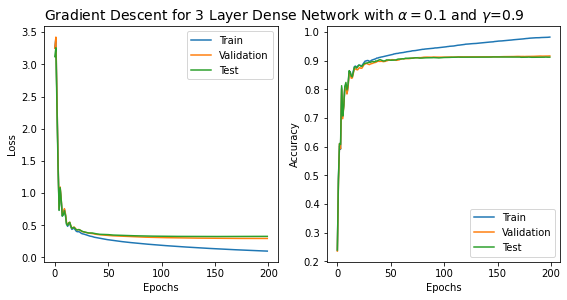

In [35]:
title = r"Gradient Descent for 3 Layer Dense Network with $\alpha={}$ and $\gamma$={}".format(0.1, 0.9)
plot_learning_history(title, three_lyr_loss_hist, three_lyr_accuracy_hist)

In [36]:
# recreate network (due to updates to class definition) and train on data
nn = Network([F, H, H, K], [ReLU(), Sigmoid(), Softmax()])
_, _, four_lyr_loss_hist, four_lyr_accuracy_hist = nn.train(Xs, Ys, CrossEntropy(), accuracy, 200)

Epoch 0 | Training Loss: 2.8376299667273237 Training Accuracy: 0.0818
Epoch 20 | Training Loss: 0.663560312462349 Training Accuracy: 0.8288
Epoch 40 | Training Loss: 0.4282862969323198 Training Accuracy: 0.8807
Epoch 60 | Training Loss: 0.35613119576216995 Training Accuracy: 0.8999
Epoch 80 | Training Loss: 0.3200581359397571 Training Accuracy: 0.9109
Epoch 100 | Training Loss: 0.2946167540244842 Training Accuracy: 0.9192
Epoch 120 | Training Loss: 0.27362372450659955 Training Accuracy: 0.9248
Epoch 140 | Training Loss: 0.25503759661155306 Training Accuracy: 0.93
Epoch 160 | Training Loss: 0.23796904447299108 Training Accuracy: 0.9336
Epoch 180 | Training Loss: 0.22195920822849335 Training Accuracy: 0.9391


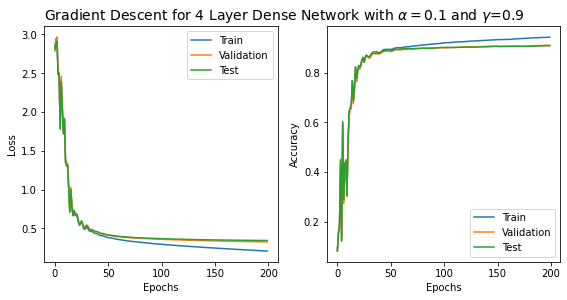

In [37]:
title = r"Gradient Descent for 4 Layer Dense Network with $\alpha={}$ and $\gamma$={}".format(0.1, 0.9)
plot_learning_history(title, four_lyr_loss_hist, four_lyr_accuracy_hist)